In [1]:
# Radar signal simulator
# ECE 435/535 Winter 2020

from matplotlib import pyplot as plt
import numpy as np
import scipy.signal as sig

# Custom libraries
import pulsetrain as pt
import pulsenoise as pn
import detection as det

# Student Libary
import lastname as GPD # Intials (George P. Burdell)

## Student Custom Library 

In [2]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

run()

### Setup the RADAR parameters

In [3]:
Pavg = 100e3        # Basic Power level output of the radar
Gt = 15             # Scalar Gain of TX antenna
Gr = Gt             # Scalar Gain of RX antenna  if Gr == Gt same antenna
fc = 40e6           # Carrier Frequency, Center Frequency
vp = 299792458      # Phase Velocity of the EM wave
NF = 1              # Receiver Noise Figure
T  = 1/fc           # period of one Carrier Frequency
#derived values
Lambda = vp/fc

# Setup Time portion
PRF = 500           # Pulses per second (hertz)
PRI = 1/PRF         # Pulse Repetition Interval (seconds)
R_unamb = PRI *vp/2 # Unambiguous Range

#Num cycles per pulse packet
k = 100             # k cycles of fc in the pulse packet
PW = k*T            # k cycles * Period of fc
BW = 1/PW           # Bandwidth of the RADAR Pulse
# error check
if PW >= PRI:
    print('Error: Pulse width much too long -- PRI: {}, PW = {}'.format(PRI, PW))


### Find R-max, R-umabigous

In [4]:
# calculate maximum range with SNR = 1, n Observations = 1
SNRmin = 1
RCS = 1
Rmax = pt.calcRmax(Pavg,Gt,Gr,Lambda, BW, SNRmin = SNRmin, RCS = RCS) #, RCS, T, NF = 1,L=1, SNRmin=1)
print('R_max(SNR:{}, RCS:{}) \t= {:.02f} km'.format(SNRmin, RCS, Rmax/1e3))
print('R_unambiguous \t\t= {:.02f} km'.format(R_unamb/1e3))


R_max(SNR:1, RCS:1) 	= 141.11 km
R_unambiguous 		= 299.79 km


# Setup the testing enviroment

In [5]:
num_targets = 10

target_ranges = np.random.randint(Rmax//4,Rmax,num_targets)
target_rcs = np.random.randint(1,1000,num_targets)


#### Time series Constraints

In [6]:
K_pulses = 20 # how many PRI's get simulated
dt_k = 20 # how many samples per fc period (Tc)
fs = dt_k*fc

#### Build the sample Pulse Train and examine

In [7]:
# Make a signal smaller in amplitude to simulate the 
# blanking / attenuation in normal RADAR systems


attenuate = True
if attenuate == True:
    dBm = -100 #dBm
    scalar = 1e-3 * np.power(10,(dBm/10))
else:
    scalar = Pavg
    
main_train, PW, dt, len_PRI = pt.createPulseTrain(A=scalar,fc = fc, k=k, PRI=PRI, dt_k=dt_k, K_pulses = K_pulses)



=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -100.00 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 


### Create the target reflections

In [8]:
# Now we create the returns...
main_trace = np.zeros_like(main_train) # return without TX

for idx, target_range in enumerate(target_ranges):

    pwr, dbm = pt.RadarEquationAdv(Pavg, Gt, target_range, RCS, Gr, Lambda, dB=False)
    print(':: idx: {} Power at RX {} dBm @ range: {} rmax {}'.format(idx,(10*np.log10(Pavg/1e-3)),
                                                                     target_range, R_unamb ))
    p_train, PW, dt, len_PRI = pt.createPulseTrain(A=pwr,fc = fc, k=k, PRI=PRI,
                                                   dt_k=dt_k, K_pulses = np.int(K_pulses))
    # time shift to correct spot
    p_train = pt.timeShift(p_train, target_range,vp, dt, len_PRI)
    main_trace = main_trace + p_train

:: idx: 0 Power at RX 80.0 dBm @ range: 35838 rmax 299792.458
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -94.13 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
191268
:: idx: 1 Power at RX 80.0 dBm @ range: 86058 rmax 299792.458
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -93.43 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
459293
:: idx: 2 Power at RX 80.0 dBm @ range: 124785 rmax 299792.458
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -96.09 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
665980
:: idx: 3 Power at RX 80.0 dBm @ range: 60355 rmax 299792.458
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -88.25 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
322116
:: idx: 4 Power at RX 80.0 dBm @ range: 137574 rmax 299792.458
=*=*=*=*=*=*=*=*=*=*=*=*=*=*

#### Merge the Transmitter Pulse train (main_train) with the reflected signals (main_trace)

#### add AWGN to the total Pulse train with returns

In [9]:
# -------------------------------
# now we add the two systems together.
# Add noise to the pulse traing
main_trace = main_trace + main_train

main_trace = pn.addNoiseToPulseTrain(main_trace,5/PW)

In [10]:
# -------------------------------
# Detection Section
# Envelope detect the signals
main_trace_env = det.envelope(main_trace)

# -------------------------------
# Gate the signal & sum them up for 
# provide n observation effects
n_obs_main_trace_env = main_trace_env.reshape(K_pulses+1, len_PRI)
# add them all together
n_obs_main_trace_env = n_obs_main_trace_env.sum(axis=0)


In [27]:
print(len(main_trace_env))
print(K_pulses)
print(len_PRI)
print(len(main_trace_env)/len_PRI)

33600000
20
1600000
21.0


(-110, -30)

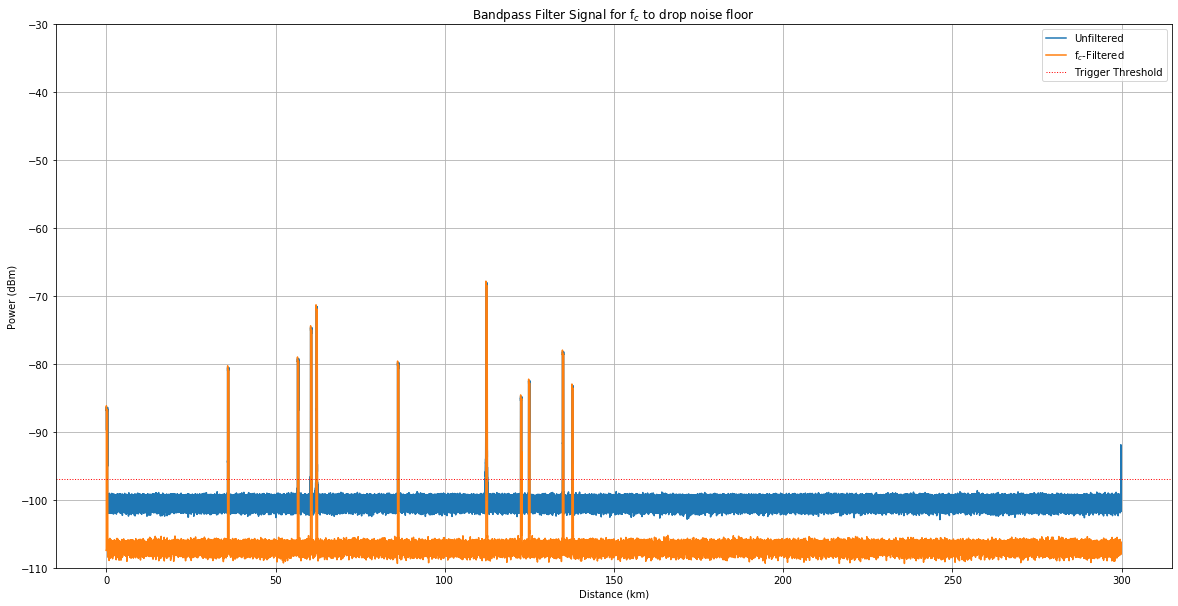

In [11]:
# Filter signal for fc - very tight filter
filt_trace = butter_bandpass_filter(main_trace, fc*0.75, fc*1.25, fs, order=7)

# Redo envelope detection on filtered signal
filt_trace_env = det.envelope(filt_trace)

# Redo gating and summing
n_obs_filt_trace_env = filt_trace_env.reshape(K_pulses+1, len_PRI)
n_obs_filt_trace_env = n_obs_filt_trace_env.sum(axis=0)

#build x-axis
nsamps = len(n_obs_main_trace_env)
x = np.linspace(0,R_unamb, nsamps)

#threshold for detecting peaks (like an oscilloscope trigger)
triggerdBm = -97
trigger = 10**((triggerdBm-30)/10)

#plot the filtered signal over the unfiltered one to show noise reduction
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(x*1e-3, 10*np.log10(n_obs_main_trace_env/1e-3), label='Unfiltered')
plt.plot(x*1e-3, 10*np.log10(n_obs_filt_trace_env/1e-3), label='f$_c$-Filtered')
plt.axhline(y=10*np.log10(trigger/1e-3), xmin=0, xmax=len(x), linewidth=1, color = 'r', linestyle='dotted', label='Trigger Threshold')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='best')
plt.title('Bandpass Filter Signal for f$_c$ to drop noise floor')
plt.xlabel('Distance (km)')
plt.ylabel('Power (dBm)')
plt.ylim(-110,-30)

(-110, -30)

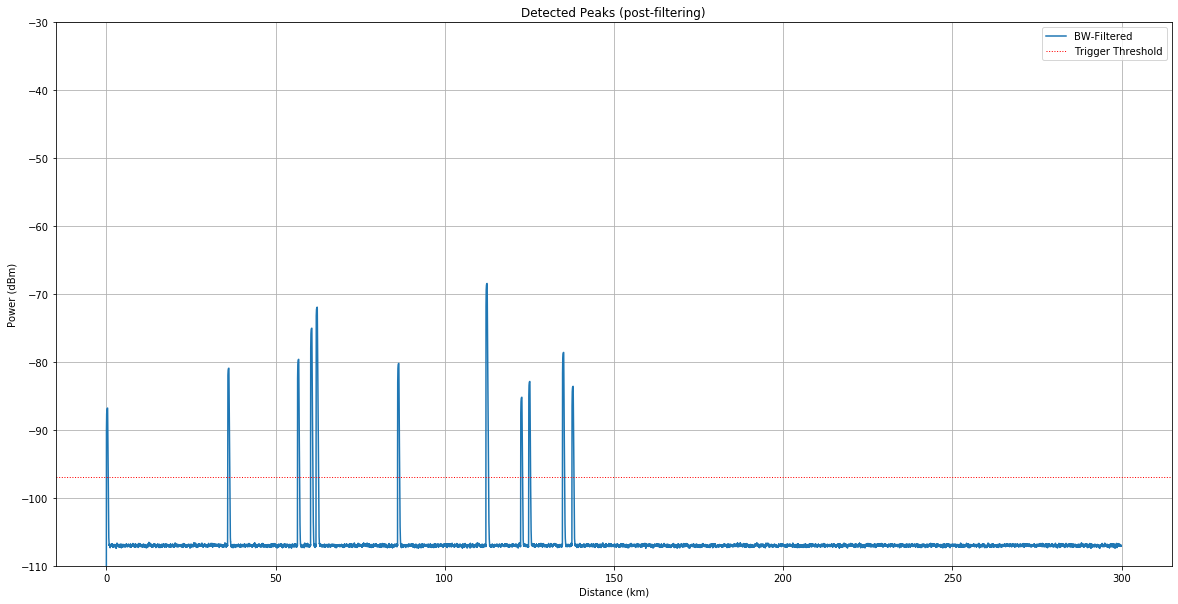

In [12]:
#filter the envelope to smooth out envelope. This will degrade the amplitude but all I need is the sample number for each peak
filt_env = butter_bandpass_filter(n_obs_filt_trace_env, 1e-20, BW, fs, order=1)

error_shift = -2020 #adjust where the peak is by this number of samples from detected peak

#make a blank list and add in each peak as these conditions are met (note: Tx peak will be first pulse detected)
maxima = list()
for idx in range(1, len(filt_env)-1):
    if filt_env[idx] > filt_env[idx-1] and\
    filt_env[idx] > filt_env[idx+1] and\
    filt_env[idx] > trigger:
        maxima.append(idx+error_shift)

#this is an array of all the sample numbers where a peak occurs above the threshold.
maxima = np.array(maxima)

#make a plot for the double-filtered signal used to detect peaks and show the trigger threshold
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(x*1e-3, 10*np.log10(np.abs(filt_env)/1e-3),label='BW-Filtered')
plt.axhline(y=10*np.log10(trigger/1e-3), xmin=0, xmax=len(filt_env), linewidth=1, color = 'r', linestyle='dotted', label='Trigger Threshold')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='best')
plt.title('Detected Peaks (post-filtering)')
plt.xlabel('Distance (km)')
plt.ylabel('Power (dBm)')
plt.ylim(-110,-30)

In [13]:
#establish the noise floor for later calculations
noisefloor = np.average(n_obs_filt_trace_env)
noisefloordBm = np.average(10*np.log10(np.abs(n_obs_filt_trace_env)/1e-3))

#headers for neato readout
print('Noise Floor at {} dBm'.format(round(noisefloordBm,1)))
print('{} Targets found above {} dBm threshold:'.format(maxima.size-1,triggerdBm))
print('')
print('      Range      Amplitude    Detection Positivity')

#average this number of samples before & after each detected peak to reduce impact of unexpected minima in the envelope waveform

TargetRange = []
for idx in range(1, len(maxima)): #note: start this index at 1 (not 0) to skip over the Tx pulse
    T_Range = vp*(maxima[idx]/fs)/(2*1000) #range in km
    TargetRange.append(T_Range)
    T_Power = np.average(n_obs_main_trace_env[(maxima[idx]-dt_k):(maxima[idx]+dt_k)])
    T_PowerdBm = 10*np.log10(np.abs(T_Power)/1e-3)
    SNRpeak = T_Power/noisefloor
    SNRpeakdB = 10*np.log10(SNRpeak)
    T_Conf = np.round(100*(1-np.exp(-SNRpeak*np.sqrt(K_pulses))),1)

    print('{: >2}: {: >7} km |{: >7} dBm |{: >7}% confidence'.format(idx, np.round(T_Range,2), np.round(T_PowerdBm,2), T_Conf))
    

Noise Floor at -106.6 dBm
10 Targets found above -97 dBm threshold:

      Range      Amplitude    Detection Positivity
 1:   35.84 km | -83.97 dBm |  100.0% confidence
 2:   56.48 km | -82.67 dBm |  100.0% confidence
 3:   60.35 km | -78.08 dBm |  100.0% confidence
 4:   61.95 km |  -74.8 dBm |  100.0% confidence
 5:   86.06 km | -83.07 dBm |  100.0% confidence
 6:  112.16 km | -71.31 dBm |  100.0% confidence
 7:  122.42 km | -87.87 dBm |  100.0% confidence
 8:  124.78 km | -85.92 dBm |  100.0% confidence
 9:  134.77 km | -81.65 dBm |  100.0% confidence
10:  137.57 km | -86.84 dBm |  100.0% confidence


(-10, 10)

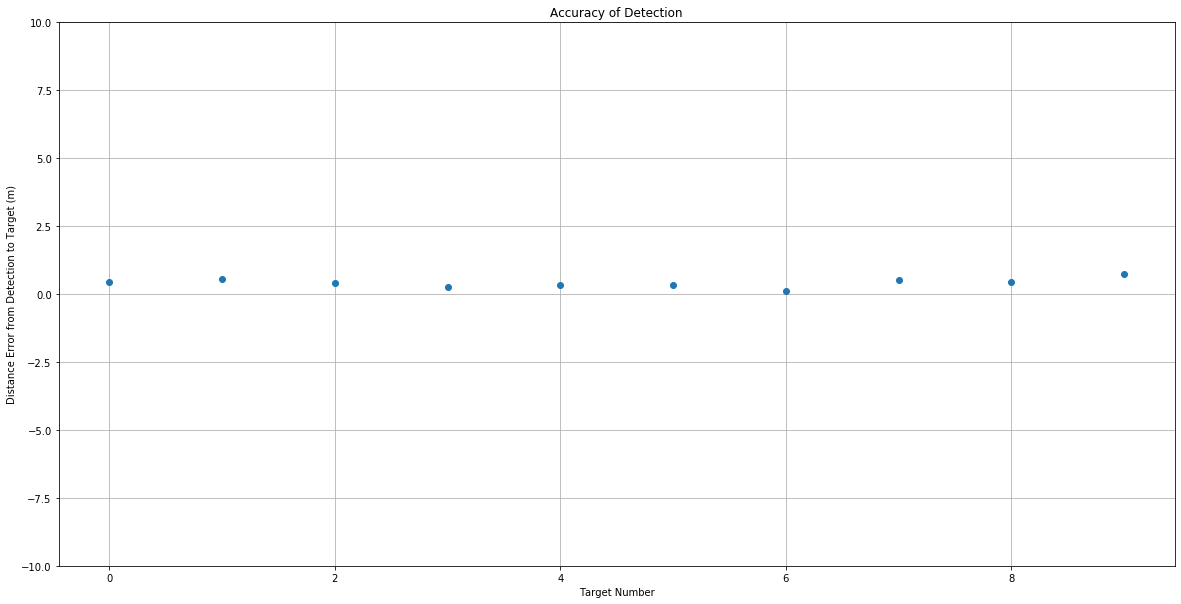

In [14]:
#Check accuracy of targets against data from target generation
xx = 1000*(np.sort(target_ranges)/1000-TargetRange)
plt.plot(xx,'o')
plt.grid(True)
plt.axis('tight')
plt.title('Accuracy of Detection')
plt.xlabel('Target Number')
plt.ylabel('Distance Error from Detection to Target (m)')
plt.ylim(-10,10)